<a href="https://colab.research.google.com/github/Manohar-123272/VQA-Project/blob/main/GEN_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import os
import shutil

# === SETUP ===
questions_path = '/kaggle/input/vqa-cocodata/v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json'
annotations_path = '/kaggle/input/vqa-cocodata/v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json'
images_dir = '/kaggle/input/vqa-cocodata/train2014/train2014'  # Folder with COCO train2014 images
output_path = 'annotated_selected_20.json'
save_images_to = 'selected_train_images'

# === Your 20 image filenames ===
selected_filenames = [
    "COCO_train2014_000000000009.jpg", "COCO_train2014_000000000025.jpg", "COCO_train2014_000000000030.jpg",
    "COCO_train2014_000000000034.jpg", "COCO_train2014_000000000036.jpg", "COCO_train2014_000000000049.jpg",
    "COCO_train2014_000000000061.jpg", "COCO_train2014_000000000064.jpg", "COCO_train2014_000000000071.jpg",
    "COCO_train2014_000000000072.jpg", "COCO_train2014_000000000077.jpg", "COCO_train2014_000000000078.jpg",
    "COCO_train2014_000000000081.jpg", "COCO_train2014_000000000086.jpg", "COCO_train2014_000000000089.jpg",
    "COCO_train2014_000000000092.jpg", "COCO_train2014_000000000094.jpg", "COCO_train2014_000000000109.jpg",
    "COCO_train2014_000000000110.jpg", "COCO_train2014_000000000113.jpg"
]

# === Convert filenames to image_ids ===
def filename_to_image_id(filename):
    return int(filename.split('_')[-1].split('.')[0])

selected_image_ids = [filename_to_image_id(f) for f in selected_filenames]

# === Load JSON files ===
def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

questions_data = load_json(questions_path)
annotations_data = load_json(annotations_path)

questions = questions_data.get('questions', [])
annotations = annotations_data.get('annotations', [])
ann_by_qid = {ann['question_id']: ann for ann in annotations}

# === Group questions by image_id ===
imgs_to_qs = {}
for q in questions:
    imgs_to_qs.setdefault(q['image_id'], []).append(q)

# === Prepare output ===
os.makedirs(save_images_to, exist_ok=True)

annotated = []
for img_id in selected_image_ids:
    entry = {
        'image_id': img_id,
        'file_name': f"COCO_train2014_{img_id:012d}.jpg",
        'image_path': os.path.join(images_dir, f"COCO_train2014_{img_id:012d}.jpg"),
        'questions': []
    }

    # Copy the image file
    src = entry['image_path']
    dst = os.path.join(save_images_to, entry['file_name'])
    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        print(f"⚠️ Warning: Image not found: {src}")

    # Add questions + annotations
    for q in imgs_to_qs.get(img_id, []):
        qid = q['question_id']
        ann = ann_by_qid.get(qid)
        qa = {
            'question_id': qid,
            'question': q['question'],
        }
        if ann:
            qa['multiple_choice_answer'] = ann.get('multiple_choice_answer')
            qa['answer_type'] = ann.get('answer_type')
            qa['question_type'] = ann.get('question_type')
            qa['answers'] = ann.get('answers')
        else:
            qa['multiple_choice_answer'] = None
            qa['answers'] = []

        entry['questions'].append(qa)

    annotated.append(entry)

# === Save to output JSON ===
with open(output_path, 'w', encoding='utf-8') as out_f:
    json.dump({'data': annotated}, out_f, ensure_ascii=False, indent=2)

print(f"\n✅ Annotated file saved to: {output_path}")
print(f"📁 Images copied to: {save_images_to}")


In [ ]:
# STEP 1: Upload zipped folder of images
from google.colab import files
import zipfile, os, shutil

uploaded = files.upload()  # Upload your .zip (e.g., my_images.zip)

# STEP 2: Unzip it to input_images/
input_zip = next(iter(uploaded))
os.makedirs("input_images", exist_ok=True)
with zipfile.ZipFile(input_zip, 'r') as zip_ref:
    zip_ref.extractall("input_images")

# STEP 3: Create separate output subfolders
output_base = "output_images"
os.makedirs(f"{output_base}/gaussian", exist_ok=True)
os.makedirs(f"{output_base}/blur", exist_ok=True)
os.makedirs(f"{output_base}/saltpepper", exist_ok=True)

# STEP 4: Install dependencies
!pip install opencv-python-headless numpy --quiet

# STEP 5: Define image transformation functions
import cv2
import numpy as np
from glob import glob

def add_gaussian_noise(image, mean=0, sigma=25):
    noise = np.random.normal(mean, sigma, image.shape).astype('uint8')
    return cv2.add(image, noise)

def add_blur(image, ksize=15):
    return cv2.GaussianBlur(image, (ksize, ksize), 0)

def add_salt_and_pepper_noise(image, amount=0.01):
    noisy = image.copy()
    row, col, ch = image.shape
    num_salt = np.ceil(amount * image.size * 0.5)
    num_pepper = np.ceil(amount * image.size * 0.5)

    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape[:2]]
    noisy[coords[0], coords[1], :] = 255

    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape[:2]]
    noisy[coords[0], coords[1], :] = 0

    return noisy

# STEP 6: Apply each effect and save in respective folders
image_paths = glob("input_images/**/*.*", recursive=True)

for path in image_paths:
    if path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        image = cv2.imread(path)
        fname = os.path.basename(path)

        cv2.imwrite(f"{output_base}/gaussian/gaussian_{fname}", add_gaussian_noise(image))
        cv2.imwrite(f"{output_base}/blur/blur_{fname}", add_blur(image))
        cv2.imwrite(f"{output_base}/saltpepper/sp_{fname}", add_salt_and_pepper_noise(image))

# STEP 7: Zip the full output_images folder
shutil.make_archive("noisy_outputs", 'zip', "output_images")

# STEP 8: Download the zip
files.download("noisy_outputs.zip")


Saving Images.zip to Images (1).zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os, json
from collections import Counter
from PIL import Image
import torch
from transformers import (
    BlipProcessor,
    BlipForQuestionAnswering,
    BlipForConditionalGeneration
)

# ==== USER CONFIGURATION ====
annotated_path       = '/content/sample_data/annotated_3.json'
image_folder         = '/content/sample_data/Images/correct_images' # original images
blurred_image_folder = '/content/sample_data/Images/gaussian_noise' # blurred images
vqa_model_name       = 'Salesforce/blip-vqa-base'
caption_model_name   = 'Salesforce/blip-image-captioning-base'

caption_mode = 'generated'   # 'correct', 'wrong', or 'generated'
image_mode   = 'gaussian'   # 'original' or 'blurred' or 'gaussian'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# =============================

def get_most_common_answer(answers):
    yes = [a['answer'].strip().lower() for a in answers if a.get('answer_confidence')=='yes']
    return Counter(yes).most_common(1)[0][0] if yes else (answers[0]['answer'].strip().lower() if answers else None)

# Load
with open(annotated_path, 'r', encoding='utf-8') as f:
    annotated = json.load(f)['data']

# Prepare models
vqa_processor = BlipProcessor.from_pretrained(vqa_model_name)
vqa_model     = BlipForQuestionAnswering.from_pretrained(vqa_model_name).to(device).eval()

cap_processor = cap_model = None
if caption_mode=='generated':
    cap_processor = BlipProcessor.from_pretrained(caption_model_name)
    cap_model     = BlipForConditionalGeneration.from_pretrained(caption_model_name).to(device).eval()

results = []
for entry in annotated:
    img_name = entry['file_name']
    # if blurred mode, expect files like "blur_<original>"
    actual_name = f"blurred_{img_name}" if image_mode == 'blurred' else (f"gaussian_{img_name}" if image_mode == 'gaussian' else img_name)
    img_path    = os.path.join(
        blurred_image_folder if image_mode=='blurred' else (blurred_image_folder if image_mode=='gaussian' else image_folder),
        actual_name
    )
    if not os.path.exists(img_path):
        print(f"[WARN] Missing image: {img_path}, skipping.")
        continue

    image = Image.open(img_path).convert('RGB')

    # pick caption
    if caption_mode=='correct':
        caption, cap_src = entry['correct_caption'], 'correct'
    elif caption_mode=='wrong':
        caption, cap_src = entry['wrong_caption'], 'wrong'
    elif caption_mode=='generated':
        cap_inputs = cap_processor(images=image, return_tensors="pt").to(device)
        cap_ids    = cap_model.generate(**cap_inputs)
        caption    = cap_processor.decode(cap_ids[0], skip_special_tokens=True)
        cap_src    = 'generated'
    else:
        caption = cap_src = None

    for q in entry['questions']:
        prompt = f"{caption}. {q['question']}" if caption else q['question']
        inputs = vqa_processor(images=image, text=prompt, return_tensors="pt").to(device)
        out_ids= vqa_model.generate(**inputs)
        pred   = vqa_processor.decode(out_ids[0], skip_special_tokens=True)
        gt     = get_most_common_answer(q['ground_truth_answers'])

        results.append({
            "image": actual_name,
            "image_mode": image_mode,
            "caption_mode": caption_mode,
            "caption_source": cap_src,
            "question_id": q['question_id'],
            "question_type": q['question_type'],
            "prompt": prompt,
            "predicted_answer": pred,
            "ground_truth": gt
        })

        print(f"{actual_name} Q#{q['question_id']} | pred={pred} | gt={gt}")

# Save
out_name = f"vqa_results_{caption_mode}_{image_mode}.json"
with open(out_name, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Saved {len(results)} entries to {out_name}")


gaussian_COCO_train2014_000000000009.jpg Q#9000 | pred=three in front | gt=2
gaussian_COCO_train2014_000000000009.jpg Q#9001 | pred=yellow | gt=pink and yellow
gaussian_COCO_train2014_000000000009.jpg Q#9002 | pred=broccoli | gt=broccoli
gaussian_COCO_train2014_000000000025.jpg Q#25000 | pred=tree | gt=tree
gaussian_COCO_train2014_000000000025.jpg Q#25001 | pred=giraffe | gt=eating
gaussian_COCO_train2014_000000000025.jpg Q#25002 | pred=yes | gt=yes
gaussian_COCO_train2014_000000000025.jpg Q#25003 | pred=eating | gt=yes
gaussian_COCO_train2014_000000000025.jpg Q#25004 | pred=in trees | gt=by tree
gaussian_COCO_train2014_000000000025.jpg Q#25005 | pred=giraffe | gt=no
gaussian_COCO_train2014_000000000025.jpg Q#25006 | pred=giraffe | gt=tree
gaussian_COCO_train2014_000000000025.jpg Q#25007 | pred=yes | gt=yes
gaussian_COCO_train2014_000000000025.jpg Q#25008 | pred=giraffe | gt=no
gaussian_COCO_train2014_000000000025.jpg Q#25009 | pred=zoo | gt=no
gaussian_COCO_train2014_000000000025.jpg 

In [ ]:

!pip install matplotlib


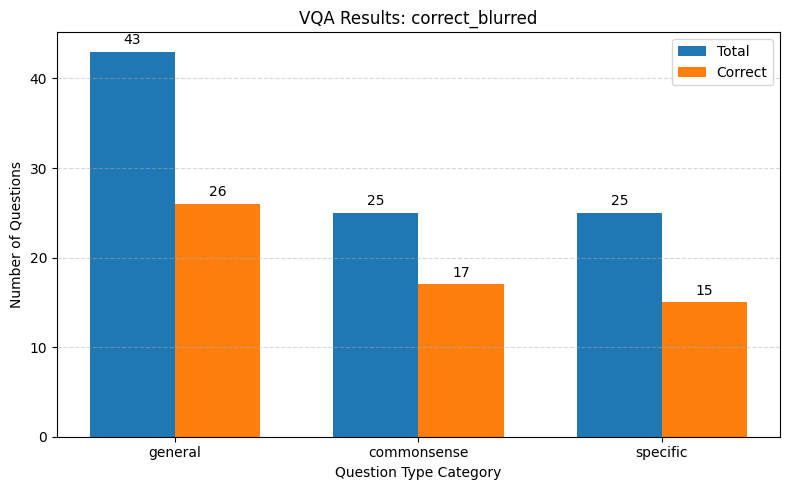

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import os

# 1) Path to your JSON file in Colab
FILE_PATH = "/content/vqa_results_correct_blurred.json"

# 2) Extract a clean title from filename
filename = os.path.basename(FILE_PATH)
title_suffix = filename.replace("vqa_results", "").replace(".json", "").lstrip("_")
plot_title = f"VQA Results: {title_suffix}"

# 3) Load the VQA results
with open(FILE_PATH, 'r') as f:
    results = json.load(f)

# 4) Normalize question types
BUCKET_MAP = {
    'general': 'general',
    'commonsense': 'commonsense',
    'common sense': 'commonsense',
    'color': 'specific',
    'colour': 'specific',
    'counting': 'specific',
    'location': 'specific',
    'Location': 'specific'
}

# 5) Count totals and corrects
totals, corrects = defaultdict(int), defaultdict(int)

for item in results:
    qt_raw = item.get("question_type", "").strip().lower()
    bucket = BUCKET_MAP.get(qt_raw, 'specific')
    totals[bucket] += 1

    pred = str(item.get("predicted_answer", "")).strip()
    gt   = str(item.get("ground_truth", "")).strip()
    if pred == gt:
        corrects[bucket] += 1

# 6) Prepare for plotting
buckets = ['general', 'commonsense', 'specific']
total_vals   = [totals[b]   for b in buckets]
correct_vals = [corrects[b] for b in buckets]

x = np.arange(len(buckets))
width = 0.35

# 7) Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars_total   = ax.bar(x - width/2, total_vals,   width, label='Total')
bars_correct = ax.bar(x + width/2, correct_vals, width, label='Correct')

ax.set_xlabel('Question Type Category')
ax.set_ylabel('Number of Questions')
ax.set_title(plot_title)
ax.set_xticks(x)
ax.set_xticklabels(buckets)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate bars
for bar in bars_total + bars_correct:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(height),
            ha='center', va='bottom')

plt.tight_layout()
plt.show()
